In [1]:
import random, os
from pathlib import Path
import numpy  as np

# do this before importing tensorflow to get rid of annoying warning messages
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
import matplotlib.pyplot as plt

In [2]:
# specify image size
target_shape = (200,200)   #(245, 200)

#### Data Preparation

#### (Also need to do some cleaning for the validation set: need to also remove duplicates from left and right image sets, because we don't want to have any left image to have multiple right image counterparts and vice versa)

In [3]:
anchor_images_path = "./dataset/left/"
positive_images_path = "./dataset/right/"
batch_size = 64
num_negatives = 10 # number of negative images for each anchor image

In [4]:
"""
    load image jpeg image from file and resize into the target shape
"""
def preprocess_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_shape)
    return img

""" 
    preprocess a triplet of images given their filenames
"""
def preprocess_triplets(anchor, positive, negative):
    return (preprocess_image(anchor), preprocess_image(positive), preprocess_image(negative))


#### Create dataset in which num_negatives triplets will have the same anchor and positive but different negative image  

In [35]:
# load anchor and positive images (make sure they're in the right order) 
anchor_images = sorted([str(anchor_images_path + f) for f in os.listdir(anchor_images_path)])
positive_images = sorted([str(positive_images_path + f) for f in os.listdir(positive_images_path)])
image_count = len(anchor_images)


# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

# randomly sample num_negatives+2 negative images for each anchor
# (we sample an extra two images to make sure we don't include any duplicates
# of the positive or anchor image in the negative images set)
num_train = int(0.8*image_count) 
num_val = image_count - num_train
zipped_set_train = []
for i in range(0, num_train):
    # randomly sample num_negatives+2 images without replacement
    negative_set = random.sample(negative_images, num_negatives+2)
    # remove any duplicates
    negative_set = [img for img in negative_set if img != anchor_images[i] and img != positive_images[i]] 
    negative_set = negative_set[:num_negatives]

    for negative_img in negative_set:
        zipped_set_train.append((anchor_images[i], positive_images[i], negative_img))    

anchor_images_train = [zipped[0] for zipped in zipped_set_train]
positive_images_train = [zipped[1] for zipped in zipped_set_train]
negative_images_train = [zipped[2] for zipped in zipped_set_train]
image_count_train = len(anchor_images_train)


num_val = image_count - num_train
zipped_set_val = []
for i in range(num_train, num_train+num_val):
    # randomly sample 3 images without replacement
    negative_set = random.sample(negative_images, 3)
    # remove any duplicates
    negative_set = [img for img in negative_set if img != anchor_images[i] and img != positive_images[i]] 
    negative_img = negative_set[0]

    zipped_set_val.append((anchor_images[i], positive_images[i], negative_img))    

anchor_images_val = [zipped[0] for zipped in zipped_set_val]
positive_images_val = [zipped[1] for zipped in zipped_set_val]
negative_images_val = [zipped[2] for zipped in zipped_set_val]
image_count_val = len(anchor_images_val)


# create tensorflow datasets
anchor_dataset_train = tf.data.Dataset.from_tensor_slices(anchor_images_train)
positive_dataset_train = tf.data.Dataset.from_tensor_slices(positive_images_train)
negative_dataset_train = tf.data.Dataset.from_tensor_slices(negative_images_train)
# create a triplet dataset
dataset_train = tf.data.Dataset.zip((anchor_dataset_train, positive_dataset_train, negative_dataset_train))
dataset_train = dataset_train.shuffle(buffer_size=1024)
# convert filenames to preprocessed images
dataset_train = dataset_train.map(preprocess_triplets) 

anchor_dataset_val = tf.data.Dataset.from_tensor_slices(anchor_images_val)
positive_dataset_val = tf.data.Dataset.from_tensor_slices(positive_images_val)
# create a negative dataset from the combined shuffled images
negative_dataset_val = tf.data.Dataset.from_tensor_slices(negative_images_val)
# create a triplet dataset
dataset_val = tf.data.Dataset.zip((anchor_dataset_val, positive_dataset_val, negative_dataset_val))
dataset_val = dataset_val.shuffle(buffer_size=1024)
# convert filenames to preprocessed images
dataset_val = dataset_val.map(preprocess_triplets) 

# create batches
train_dataset = dataset_train.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(16)
val_dataset = dataset_val.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(16)

#### Visualising the dataset

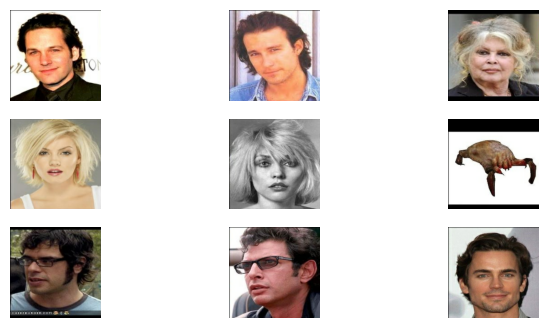

In [36]:
def visualize(anchor, positive, negative_set):
    
    def show(ax, image):
        ax.imshow(image)
        ax.axis('off')
        

    fig = plt.figure(figsize=(8, 4))
    axs = fig.subplots(3, 3)
        
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative_set[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


#### Feature extractor network 

We will use ResNet50, pretrained on ImageNet, to extract features from the images. All layers preceding `conv5_block1_out` will be frozen, the weights in the remaining layers above will be fine-tuned

In [37]:
feature_dims = 128

base_cnn = resnet.ResNet50(weights="imagenet", input_shape=target_shape + (3,), include_top=False) # we do not include the ResNet50 output layer

# additional layers on top of resnet 
flatten = layers.Flatten() (base_cnn.output)
output = layers.Dense(512, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(256, activation='relu')(flatten)
output = layers.BatchNormalization()(output)
output = layers.Dense(feature_dims, activation='relu')(flatten)

# combine into a new model
feature_extractor = Model(base_cnn.input, output, name="feature_extractor")

# freeze the weights up to layer conv5_block1_out
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

feature_extractor.summary()

Model: "feature_extractor"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                  

#### Siamese network with custom training loop 

The siamese network takes each of the triplet images, extracts features and outputs the L2-distance between the achor image and positive and negative images. The triplet loss function is used to compute the loss, defined as follows:

$L(A,P,N) = Max(Dist(A,P) - Dist(A,N) + margin, 0.0)$

In [38]:
"""
    A custom layer for computing the distance between extracted features of anchor image and positive/negative images
"""
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative_set):
        # compute l2-distance between anchor and positive image
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        # compute average l2-distance between anchor and negative images
        an_distance = tf.reduce_mean(tf.reduce_sum(tf.square(anchor - negative_set), -1), -1)
        return (ap_distance, an_distance)
    

anchor_input = layers.Input(shape=target_shape + (3,), name="anchor")    
positive_input = layers.Input(shape=target_shape + (3,), name="positive")    
negative_input = layers.Input(shape=target_shape + (3,), name="negative")    

distances = DistanceLayer()(feature_extractor(anchor_input), feature_extractor(positive_input), feature_extractor(negative_input))

# define the siamese network model
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs = distances)

In [39]:
# define custom training loop
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
  

    def call(self, inputs):    
        return self.siamese_network(inputs)
    

    # custom training step    
    def train_step(self, data):
        # forward propagation on gradient tape
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # compute the loss gradients 
        grads = tape.gradient(loss, self.siamese_network.trainable_weights)

        # backproagation
        self.optimizer.apply_gradients(zip(grads,self.siamese_network.trainable_weights))

        # update the loss metric
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
     

    # custom testing step
    def test_step(self, data):
        loss = self._compute_loss(data)
        # update the loss metric.
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}


    # define the triplet loss function
    def _compute_loss(self, data):
        # compute distance of anchor from positive and negative images
        ap_distance, an_distance = self.siamese_network(data)
        # compute the triplet loss (we want to minimize ap_distance and maximise an_distance,
        # which is why there's a minus sign infront of an_distance, we also allow for a small margin) 
        loss = ap_distance - an_distance + self.margin   
        # make sure the loss value is non-negative
        loss = tf.maximum(loss, 0.0)
        
        return loss


    @property
    def metrics(self):
        return [self.loss_tracker]

#### Now, let's train this model

In [40]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001))

In [41]:
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


#### Evaluating the trained siamese network on the validation dataset

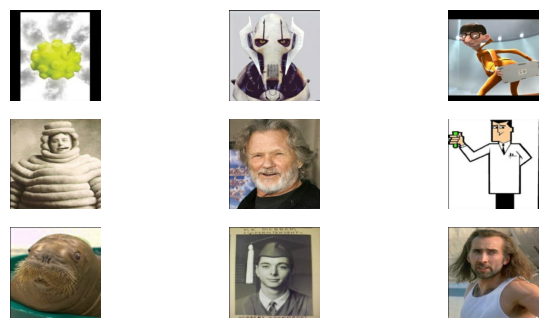

In [ ]:
# pick a sample triplet
sample = next(iter(val_dataset))
visualize(*sample)

#### Compute the l2 distance between the anchor and positive/negative images

In [ ]:
anchor, positive, negative = sample

anchor_features, positive_features, negative_features = (feature_extractor(resnet.preprocess_input(anchor)), feature_extractor(resnet.preprocess_input(positive)), feature_extractor(resnet.preprocess_input(negative)))

In [ ]:
mse = metrics.MeanSquaredError()

positive_distance = mse(anchor_features, positive_features)
negative_distance = mse(anchor_features, negative_features)

print(f"Dist(A,P) = {positive_distance.numpy()}, Dist(A,N) = {negative_distance.numpy()}")

Dist(A,P) = 0.004151247441768646, Dist(A,N) = 0.003991958685219288


In [ ]:
num_correct = 0
i = 0
for (anchor_batch, positive_batch, negative_batch) in val_dataset:
    #print(anchor_batch.numpy().shape)
    #print(positive_batch.numpy().shape)
    #print(negative_batch.numpy().shape)
    for (anchor, positive, negative) in zip(anchor_batch, positive_batch, negative_batch):
        anchor = tf.expand_dims(anchor, axis=0)
        positive = tf.expand_dims(positive, axis=0)
        negative = tf.expand_dims(negative, axis=0)
        anchor_features, positive_features, negative_features = (feature_extractor(resnet.preprocess_input(anchor)), feature_extractor(resnet.preprocess_input(positive)), feature_extractor(resnet.preprocess_input(negative)))
        
        positive_distance = mse(anchor_features, positive_features)
        negative_distance = mse(anchor_features, negative_features)
        correct = positive_distance.numpy() < negative_distance.numpy()
        if correct:
            num_correct += 1

        print(f"Sample#{i} --> Dist(A,P) = {positive_distance.numpy()}, Dist(A,N) = {negative_distance.numpy()} Correct: {correct}")
        i += 1

    print(f"Accuracy = {num_correct/(i+1)}")

Sample#0 --> Dist(A,P) = 0.003995692357420921, Dist(A,N) = 0.003966611344367266 Correct: False
Sample#1 --> Dist(A,P) = 0.004030250478535891, Dist(A,N) = 0.004029030911624432 Correct: False
Sample#2 --> Dist(A,P) = 0.004005188588052988, Dist(A,N) = 0.004008171614259481 Correct: True
Sample#3 --> Dist(A,P) = 0.004032986704260111, Dist(A,N) = 0.004011823330074549 Correct: False
Sample#4 --> Dist(A,P) = 0.003997317515313625, Dist(A,N) = 0.004091509152203798 Correct: True
Sample#5 --> Dist(A,P) = 0.004089232999831438, Dist(A,N) = 0.004065456334501505 Correct: False
Sample#6 --> Dist(A,P) = 0.004050679504871368, Dist(A,N) = 0.004040668252855539 Correct: False
Sample#7 --> Dist(A,P) = 0.004014309495687485, Dist(A,N) = 0.00399049511179328 Correct: False
Sample#8 --> Dist(A,P) = 0.00400014640763402, Dist(A,N) = 0.003998418804258108 Correct: False
Sample#9 --> Dist(A,P) = 0.004169991239905357, Dist(A,N) = 0.004463432356715202 Correct: True
Sample#10 --> Dist(A,P) = 0.0044371141120791435, Dist(A

KeyboardInterrupt: 

#### For only 36% of the validation set triplets, the l2 distance for the positive image is lower than l2 distance of negative image. So the performance is quite poor.